# Sequential Quantum Enhanced Training (SEQUENT)

This notebook defines a classical-quantum hybrid architecture and two-step training procedure for *Seguential Quantum Enhanced Training* (SEQUENT) applied to non-linear classification problems and copared to hybrid *dressed quantum circuits* (DQC) and classical feed-forward neural networks. 

This notebook is inspired by Xanadu's [quantum transfer learning](https://github.com/XanaduAI/quantum-transfer-learning) notebook collection and the sci-kit learn "[classifier comparison](https://github.com/scikit-learn/scikit-learn/blob/master/examples/classification/plot_classifier_comparison.py) example. 

## General setup
This notebook requires the following packages: pennylane, pytorch, numpy, scikit learn and matplot lib.

In [1]:
# %pip install pennylane
# %pip install torch
# %pip install numpy
# %pip install scikit_learn
# %pip install matplot

In [2]:
import time
import random 
import pennylane as qml
import numpy as np
import torch as th

w,d = 6,10
seed = 7             # Seed for random initial weights
random.seed(seed); np.random.seed(seed); th.manual_seed(seed)
input_size, num_classes = 2, 2 
setgrad = lambda g, *ms: [setattr(p,'requires_grad', g) for m in ms for p in m.parameters() ]

## Variational Quantum Circuit

First, let us define some preliminary quantum layers that will compose the quantum circuit.

In [3]:
"""Layer of single-qubit Hadamard gates. """
def Hadamard(nqubits):return [qml.Hadamard(wires=idx) for idx in range(nqubits)]
        
"""Layer of parametrized qubit rotations around the y axis."""
def Rotation(w):return [qml.RY(element, wires=idx) for idx, element in enumerate(w)]

"""Layer of shifted CNots."""
def CNot(start, nqubits):return [qml.CNOT(wires=[i, i + 1]) for i in range(start, nqubits - 1, 2)] 

"""Layer of CNOTs followed by another shifted layer of CNOTs and a Rotation Layer"""   
def Entangle(weights): return [[*CNot(0, len(w)), *CNot(1, len(w)), *Rotation(w)] for w in weights]

"""Expectation values in the Z basis."""
def Measure(wires):return [qml.expval(qml.PauliZ(position)) for position in wires]   

We can now define the quantum circuit by using the PennyLane `qnode` decorator . The structure is that of a typical
variational quantum circuit:
1. All qubits are first initialized in a balanced superposition of *up* and *down* states, then they are rotated according to the input parameters (local embedding);
2. Successively a sequence of trainable rotation layers and constant entangling layers is applied. This block is responsible for the main computation necessary to solve the classification problem.
3. Eventually, for each qubit, the local expectation value of the Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [4]:
dev = qml.device('lightning.qubit', wires=w)

@qml.qnode(dev, interface="torch", diff_method='adjoint')
def variational_circuit(input, weights, out):
  width = weights.shape[1]; assert input.shape[0] == width, f"Expected input of len {width}"
  input = input * np.pi / 2.0   # Rescale [-1,1] to [-pi/2,pi/2]
  Hadamard(width)               # Start from state |+> , unbiased w.r.t. |0> and |1>
  Rotation(input)               # Embed features in the quantum node 
  Entangle(weights)             # Sequence of trainable variational layers
  return Measure(range(out))    # Expectation values in the Z basis

input,params = th.randn(w), th.nn.Parameter(th.randn(d, w))
print(qml.draw(variational_circuit)(input, params, w))

0: ──H──RY(-0.23)─╭●──RY(0.61)─────────────╭●──RY(1.93)─────────────╭●──RY(-0.21)────────────╭●
1: ──H──RY(1.23)──╰X─╭●──────────RY(-0.58)─╰X─╭●──────────RY(-0.33)─╰X─╭●──────────RY(-0.22)─╰X
2: ──H──RY(1.49)──╭●─╰X──────────RY(0.05)──╭●─╰X──────────RY(-0.55)─╭●─╰X──────────RY(-1.82)─╭●
3: ──H──RY(-1.75)─╰X─╭●──────────RY(-0.32)─╰X─╭●──────────RY(0.35)──╰X─╭●──────────RY(-0.35)─╰X
4: ──H──RY(2.66)──╭●─╰X──────────RY(-1.58)─╭●─╰X──────────RY(-1.08)─╭●─╰X──────────RY(-1.30)─╭●
5: ──H──RY(-1.41)─╰X──RY(-0.32)────────────╰X──RY(-0.89)────────────╰X──RY(0.09)─────────────╰X

───RY(-1.38)────────────╭●──RY(1.10)────────────╭●──RY(1.64)─────────────╭●──RY(-0.18)────────────╭●
──╭●──────────RY(0.50)──╰X─╭●─────────RY(0.48)──╰X─╭●──────────RY(-1.06)─╰X─╭●──────────RY(-0.26)─╰X
──╰X──────────RY(-0.08)─╭●─╰X─────────RY(1.40)──╭●─╰X──────────RY(2.51)──╭●─╰X──────────RY(-0.01)─╭●
──╭●──────────RY(-0.02)─╰X─╭●─────────RY(1.41)──╰X─╭●──────────RY(-1.25)─╰X─╭●──────────RY(-0.38)─╰X
──╰X──────────RY(0.

Finally, let us setup a trainable Circuit using pytorch

In [5]:
class Circuit(th.nn.Module):
  def __init__(self, width, depth, out):
    super().__init__(); self.out = out
    self.params = th.nn.Parameter(th.randn(depth, width))
  
  def forward(self, input): 
    if len(input.shape) > 1: return th.cat([self(i).float().unsqueeze(0) for i in input])
    return variational_circuit(input, self.params, self.out)

## Dressed Quantum Circuit 
A _dressed quantum circuit_ [arXiv:1912.08278](https://arxiv.org/abs/1912.08278) is a variational quancum circuit "sandwiched" between two classical pre- and post-processing layers.

Our implementation supports three training modes: 
-  `"classical"`: Only pre- and post-processing weights are adapted 
-  `"quantum"`: Only variational quantum circuit weights are adapted 
-  `"hybrid"`: All weights are concurently trained

In [6]:
class DressedQuantumCircuit(th.nn.Module):
  def __init__(self, width, depth, i=input_size, o=num_classes):
    """ :param i,o: Input, Output dimension, :params width, depth: Internal net width (i.e. n_qubits) and depth (number of variational layers)"""
    super().__init__()
    self.pre_processing  = th.nn.Sequential(th.nn.Linear(i, width), th.nn.Tanh()) 
    self.circuit = Circuit(width, depth, width)
    self.post_processing = th.nn.Linear(width, o)
  
  def train(self, mode): 
    if mode == 'classical': setgrad(True, self.pre_processing, self.post_processing); setgrad(False, self.circuit)
    if mode == 'quantum': setgrad(True, self.circuit); setgrad(False, self.pre_processing, self.post_processing)
    if mode == 'hybrid': setgrad(True, self.pre_processing, self.circuit, self.post_processing)

  def forward(self, input): return self.post_processing(self.circuit(self.pre_processing(input.float())))

## Sequential Qunatum Enhanced Training (SEQUENT)

Now, let us define the *SEQUENT* Architecture, consisting only of two layers: a compression layer to map input_size -> n_qubits, and a classification layer to map n_qubits -> num_classes. Depending on the chosen mode, the classification may either be a _classical_ linear layer, or a quantum variational circuit. 
Again, three training modes are supported:
-  `"classical"`: Weights of the classical compression layer and the classification surrogate layer are updated.
-  `"quantum"`: All classical weights are frozen, and the surrogatae is replaced by the quantum variational circuit to be trained.
-  `"hybrid"`: Both the classical compression layer- and quantum variation circuit weigths are trained concurrently.

In [7]:
class SEQUENT(th.nn.Module):
  """ Sequential Quantum Enhanced Training (SEQUENT) """
  def __init__(self, width, depth, i=input_size, o=num_classes):
    """ :params i,o: Input, Output dimension, :params width, depth: Internal net width (i.e. n_qubits) and depth (number of variational layers)"""
    super().__init__()
    self.compression  = th.nn.Sequential(th.nn.Linear(i, width), th.nn.Tanh()) 
    self.surrogate = th.nn.Sequential(th.nn.Linear(width, o)) #th.nn.Sequential(*[th.nn.Linear(width,width), th.nn.Tanh()]*depth)
    self.circuit = Circuit(width, depth, o)

  def train(self, mode): 
    if mode == 'classical': self.classification = self.surrogate; setgrad(False, self.circuit); setgrad(True, self.compression, self.surrogate)
    if mode == 'quantum': self.classification = self.circuit; setgrad(True, self.circuit); setgrad(False, self.compression, self.surrogate)
    if mode == 'hybrid': self.classification = self.circuit; setgrad(True, self.compression, self.circuit); setgrad(False, self.surrogate)

  def forward(self, input): return self.classification(self.compression(input.float()))

## Feed Forward Network

Finally let us define a purely classical feed forward network architecture with one n_qubits-sized hidden layer that will serve as a baselien

In [8]:
class FeedForwardNetwork(th.nn.Module):
  """ Classical Feed Forward Neual Network with one hidden layer """
  def __init__(self, width, i=input_size, o=num_classes):
    """ :params i,o: Input, Output dimension :params width, depth: Internal net width (i.e. n_qubits) and depth (number of variational layers)"""
    super().__init__()
    self.compression  = th.nn.Sequential(th.nn.Linear(i, width), th.nn.Tanh()) 
    self.classification = th.nn.Sequential(th.nn.Linear(width, o)) #th.nn.Sequential(*[th.nn.Linear(width,width), th.nn.Tanh()]*depth)
  def train(self, stage): assert stage == 'classical'
  def forward(self, input): return self.classification(self.compression(input.float()))

## Synthetic benchmark datasets 
Generate two groups of 2D points. Two-dimensional datasets are very instructive because they can be easily visualized.

In [9]:
# Plotting
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Scikit-learn tools
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

In [10]:
class Dataset:
  def __init__(self, name, generator, train_size=2000, test_size=200, n_classes=2):
    X, y = generator(train_size + test_size);self.train_size = train_size; self.name = name
    self.X = StandardScaler().fit_transform(X); self.y = self.one_hot(y, n_classes)
    self.train, self.test = th.utils.data.random_split(list(zip(self.X,self.y)), [train_size, test_size])
    
  def __len__(self): return len(self.train)
    
  def sample(self, batch):
    if batch == 'test': X,y = zip(*list(self.test)); return th.tensor(np.array(X)), th.tensor(np.array(y))
    return th.utils.data.DataLoader(self.train, batch_size=batch, shuffle=True)
  
  def one_hot(self, labels, classes):
    """One-hot encoding of a batch of vectors. """
    return np.eye(classes)[labels]

  def classes(self, labels):
    """Inverse of digits2position()."""
    if len(labels.shape) > 1: return [self.classes(l) for l in labels]
    return np.argmax(labels)

  def _grid(self, size=0.2):
    # Plot settings
    x_min, x_max = self.X[:, 0].min() - .5, self.X[:, 0].max() + .5
    y_min, y_max = self.X[:, 1].min() - .5, self.X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),np.arange(y_min, y_max, size))
    return xx, yy
    
  def plot(self, ax, model=None, score=None):
    # Plot training & points
    cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Train point colors
    X, y = zip(*list(self.train)); X_train = np.array(X); y_train = self.classes(np.array(y))
    X, y = zip(*list(self.test)); X_test = np.array(X); y_test = self.classes(np.array(y))
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k',alpha=0.1)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k')
    if model is None: return
  
    # In order to draw the decision border we compute predictions for the whole 2D plane.
    xx, yy = self._grid(); 
    X = th.tensor(list(zip(xx.ravel(), yy.ravel())))
    Z = (th.argmax(model(X), 1).cpu().numpy() * 2 - 1).reshape(xx.shape)
    # Z = np.tanh(grid_results[:, 1] - grid_results[:, 0])
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
    ax.set_xlim(xx.min(), xx.max()); ax.set_ylim(yy.min(), yy.max()); ax.set_xticks(()); ax.set_yticks(())
    if score is not None: ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')


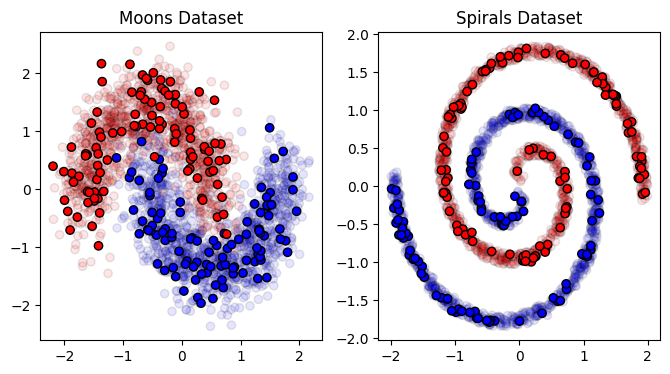

In [11]:
def twospirals(n_points, noise=0.7, turns=1.52):
  """Returns the two spirals dataset.""" 
  n_points = n_points // 2
  n = np.sqrt(np.random.rand(n_points, 1)) * turns * (2 * np.pi)
  d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
  d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
  return (np.vstack((np.hstack((d1x,  d1y)),np.hstack((-d1x, -d1y)))), 
          np.hstack((np.zeros(n_points).astype(int),np.ones(n_points).astype(int))))


spirals = Dataset('Spirals', lambda size: twospirals(size, turns=1.52))
moons =  Dataset('Moons', lambda size: make_moons(size, noise=0.2))

# Plot the dataset
dataset_figures = plt.figure("dataset",figsize=(8, 4))
moons.plot(plt.subplot(1,2,1, title=f"Moons Dataset"))
spirals.plot(plt.subplot(1,2,2, title=f"Spirals Dataset"))

Red and blue colors are the two classes that we want to distinguish.<br>
The vivid points in the foreground are the test data, while the pale points in the background are the training data.<br> 

## Training Process
First let us define the traing process

In [12]:
# =============================== #
#       Network training          # 
# =============================== #
def train(model, dataset, stages, epochs=8, batch_size=10, lr=0.1, criterion=th.nn.CrossEntropyLoss(), optimizer=th.optim.Adam):
  print(f'Training: {model.__class__.__name__} on {dataset.name} |                                                                               ', end='\r', flush=True)
  batches = len(dataset)/batch_size
  optimizer = optimizer(model.parameters(), lr=lr)
  for stage in stages:
    for epoch in range(epochs): 
      model.train(stage)
      running_loss, running_corrects = 0.0, 0
      for i, (X,y) in enumerate(dataset.sample(batch_size)):
        _start = time.time(); target = th.max(y, 1)[1]
        optimizer.zero_grad(); outputs = model(X)
        preds = th.max(outputs, 1)[1]
        loss = criterion(outputs, y)
        loss.backward(); optimizer.step()
    
        # Print iteration results
        running_loss += loss.item() * batch_size; running_corrects += th.sum(preds == target).item(); 
        print(f'Training: {model.__class__.__name__} on {dataset.name} | Epoch: {epoch+1}/{epochs} Iter: {i}/{batches:.0f} Time: {time.time()-_start:.4f}', end='\r', flush=True)
      acc = running_corrects / len(dataset); loss = running_loss / len(dataset)
      print(f'Training: {model.__class__.__name__} on {dataset.name} | Epoch: {epoch+1}/{epochs} Iter: {i}/{batches:.0f} Time: {time.time()-_start:.4f} Loss: {loss:.4f} Acc: {acc:.4f} ', end='\r', flush=True)

  return model

as well as a testing and vizualisation procedure

In [13]:
# ================================ #
#        Network testing           #
# ================================ #
def test(model, dataset):
  X,y = dataset.sample('test')
  with th.no_grad():  preds = th.argmax(model(X), 1); target = th.max(y, 1)[1]; accuracy = th.sum(preds == target).item() / len(y)
  print(f'Trained: {model.__class__.__name__} on {dataset.name}  with Accuracy {accuracy:4.3f}                                                     ')
  return accuracy
        

# SEQUENT Training
No let us finally train SEQUENT on booth dataset and compare it to the Dressed Quantum Circuit and the Classically Trained Feed Forward Network.

Loop over datasets and algorithms (dressed quantum, fully classical). For each dataset and algorithm, independent training and test processes are performed. The results are graphically shown when the training loop is completed.

In [14]:
# Initialize models for test datasets
models = [(name, cls(**args), data, stages, epochs, m*2+(-d+2)) 
  for m,(name,(cls,args, stages)) in enumerate({
    'SEQUENT': (SEQUENT, dict(width=w, depth=d), ['classical', 'quantum']),
    'DQC': (DressedQuantumCircuit, dict(width=w, depth=d), ['hybrid']),
    'Classical': (FeedForwardNetwork, dict(width=w),  ['classical'])
  }.items()) for d, (data,epochs) in enumerate([(spirals,4),(moons,2)])] 

Trained: SEQUENT on Spirals  with Accuracy 0.865                                                             
Trained: SEQUENT on Moons  with Accuracy 0.975                                                             
Trained: DressedQuantumCircuit on Spirals  with Accuracy 0.815                                                             
Trained: DressedQuantumCircuit on Moons  with Accuracy 0.950                                                             
Trained: FeedForwardNetwork on Spirals  with Accuracy 0.785                                                             
Trained: FeedForwardNetwork on Moons  with Accuracy 0.965                                                             


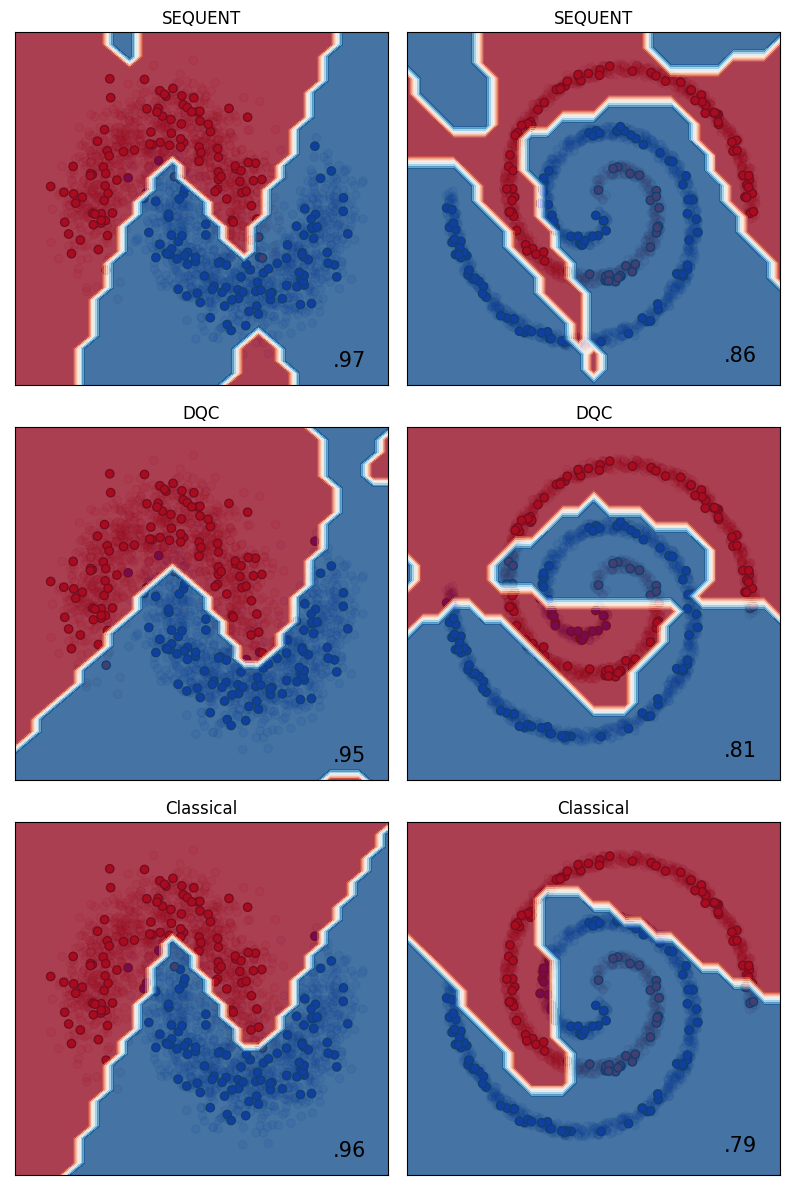

In [15]:
# Train for 1. Epoch
plt.figure("main",figsize=(4*2,4*3))
for name,model,data,stages,epochs,i in models:
  train(model, data, stages, epochs=epochs)
  with th.no_grad(): data.plot(plt.subplot(3, 2, i, title=name), model, test(model, data))
plt.tight_layout(); plt.show()